**Image Classification on American Sign Language**  
USD - AAI-521 Computer Vision for AI  
_Group 7: Kenneth Devoe, Vannesa Laxamana, Johnathan Long_  
___

###**Dataset Selection**  
The Sign Language MNIST dataset offers a challenging alternative to the classic MNIST dataset, focusing on 24 American Sign Language (ASL) hand gestures, excluding 'J' and 'Z' due to their motion requirements. It mirrors the original MNIST structure, with 28x28 grayscale images flattened into rows, but presents added complexity due to gesture variations and inter-class similarity.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from google.colab import drive

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> Let's load the dataset and visualize the output to familiarize ourselves. Dataset contains pixel values within two CSV files `[sign_mnist_train , sign_mnist_test]`. We normalize the pixels and plot 5 random images along with their associative pre-mapped labels.

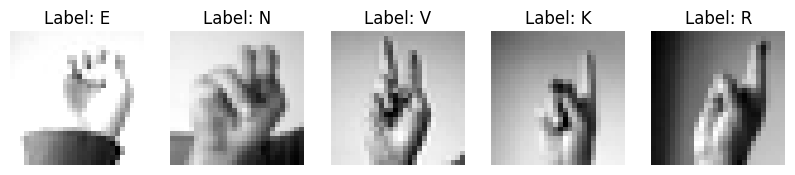

In [ ]:

# Load the dataset
train_data_path = "/content/drive/MyDrive/Datasets/Sign_Language_MNIST/sign_mnist_train.csv"  # Replace with the path to the training dataset CSV file
test_data_path = "/content/drive/MyDrive/Datasets/Sign_Language_MNIST/sign_mnist_test.csv"    # Replace with the path to the test dataset CSV file

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Separate labels and pixel values
train_labels = train_data.iloc[:, 0].values  # First column contains the labels
train_images = train_data.iloc[:, 1:].values  # Remaining columns contain the pixel values

# Normalize the pixel values (optional but recommended)
train_images = train_images / 255.0

# Visualize random images
def plot_random_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        idx = np.random.randint(0, len(images))  # Pick a random image
        image = images[idx].reshape(28, 28)  # Reshape to 28x28
        label = labels[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {chr(label + 65)}")  # Convert label (0-25) to letter (A-Z)
        plt.axis('off')
    plt.show()

# Plot 5 random images from the training set
plot_random_images(train_images, train_labels)


In [ ]:
# Overview of the dataset
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


**Dataset Overview:**  
>The training set at approximately 80% of the complete dataset contains 27,455 instances of many image variations and 784 features (1 label column).  _Class Labels_ are 24 integers (0-23), corresponding to letters A-Y (excluding J and Z due to their motion dependencies).
>
>Training Data Shape:  [27,455 , 785]  
>Test Data Shape:  [7,172 , 785]  


In [ ]:
miss = train_data.isnull().values.any()
print(f"Missing values: {miss}")
print("Dataset Shape:", train_data.shape)
print("Test Dataset Shape:", test_data.shape)
print("Unique Labels:", train_data['label'].nunique())

Missing values: False
Dataset Shape: (27455, 785)
Test Dataset Shape: (7172, 785)
Unique Labels: 24


**Pixel Values:**  
>The dataset uses 8-bit grayscale images with pixel values ranging from 0 to 255. The mean pixel intensity range (145–165) indicates the images are relatively bright, while the standard deviation range (31–65) reflects varying levels of contrast and brightness consistency. These characteristics suggest the images are well-lit but may benefit from normalization (scaling values to 0–1) to ensure better consistency and model performance during training.

In [ ]:
# Summary of pixel values
pixel_summary = train_data.iloc[:, 1:].describe()
pixel_summary


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,165.533673,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,31.279244,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,148.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,167.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,186.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


**Class Distribution:**  
>We print the distribution of characters to confirm that there is not an uneven distribution that may result in bias. The Distribution here is relatively balanced with slight variations across classes

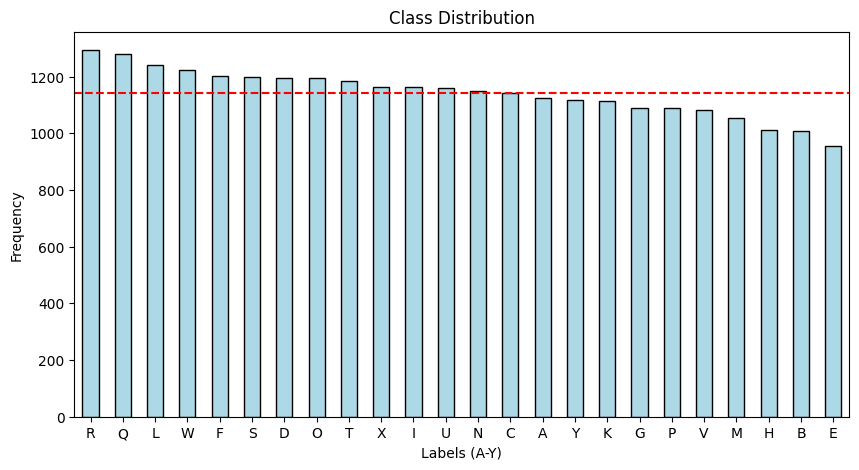

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Check for class distribution
class_distribution = train_data['label'].value_counts()

# Convert labels to letters (A-Z)
class_distribution.index = class_distribution.index.map(lambda x: chr(x + 65))

# Visualize the class distribution
class_distribution.plot(kind='bar', figsize=(10, 5), color='lightblue', edgecolor='black', title='Class Distribution')
plt.xlabel('Labels (A-Y)')
plt.axhline(y=class_distribution.mean(), color='red', linestyle='--', label='Mean Count')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()


**Label Mapping:**  
>Lastly we confirm the class/label matching by printing a list of the characters and their class correlations. We can see here that letters "J" and "Z" are already ommitted.

In [ ]:
def list_all_classes(labels):
    class_letters = {}
    for label in range(26):  # Iterate over labels 0–25
        if label in labels:
            class_letters[label] = chr(label + 65)  # Map class number to letter

    for class_num, letter in class_letters.items():
        print(f"Class {class_num}: {letter}")

# List all classes with their associated letters
list_all_classes(train_labels)


Class 0: A
Class 1: B
Class 2: C
Class 3: D
Class 4: E
Class 5: F
Class 6: G
Class 7: H
Class 8: I
Class 10: K
Class 11: L
Class 12: M
Class 13: N
Class 14: O
Class 15: P
Class 16: Q
Class 17: R
Class 18: S
Class 19: T
Class 20: U
Class 21: V
Class 22: W
Class 23: X
Class 24: Y


___
###**Model Selection & Training**
> We prepare the image data for training with the Mobilenetv3small model by resizing images to 96x96 pixels, converting them from grayscale to RGB, and normalizing pixel values to the range [0, 1]. It one-hot encodes the labels for classification. The code splits the `train_data` DataFrame into 90% for training and 10% for validation. We then load the training, validation, and test datasets using the `load_dataset_from_dataframe` function. The datasets are shuffled, batched, and prefetched to optimize training performance, with the test set reserved for final evaluation after training

In [ ]:
# Define constants for data handling
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 26

# Create tf.data.Dataset for Training and Test Data
def preprocess_image(image, label):
    # Reshape to 28x28 and add channel dimension
    image = tf.reshape(image, [28, 28, 1])
    # Resize to 96x96
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Convert grayscale (1 channel) to RGB (3 channels)
    image = tf.image.grayscale_to_rgb(image)
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset_from_dataframe(dataframe):
    # Extract features and labels
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values

    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Prepare training, validation, and test datasets
train_val_split = int(len(train_data) * 0.9)
train_df = train_data.iloc[:train_val_split]
val_df = train_data.iloc[train_val_split:]

train_dataset = load_dataset_from_dataframe(train_df)
val_dataset = load_dataset_from_dataframe(val_df)
test_dataset = load_dataset_from_dataframe(test_data)

**Model Architecture**  
> Now we use the `create_model` function to build learning model using a pre-trained MobileNetV3 Small as the base, with a custom classification head. The model is then fine-tuned. The Adam optimizer is used with a very small learning rate of 0.00001, and categorical crossentropy is chosen as the loss function for multi-class classification.

- `Input(shape=(img_height, img_width, 3))`: Defines the input layer for the model, which takes images of shape `(img_height, img_width, 3)`.  

- `base_model(inputs, training=False)`: Passes the input through the pre-trained MobileNetV3 base model. The training=False ensures that the batch normalization layers use their learned moving statistics instead of batch-specific statistics.  

- `GlobalAveragePooling2D()(x)`: Applies global average pooling, reducing the spatial dimensions of the feature map to a single value per channel. This helps reduce the number of parameters and avoid overfitting.  

- `ense(dense_size, activation='relu')(x)`: A fully connected (dense) layer with dense_size units and ReLU activation. This layer learns higher-level features.  

- `Dropout(dropout_rate)(x)`: Adds a dropout layer with the specified dropout_rate (default 0.5). This helps regularize the model by randomly setting a fraction of input units to 0 during training, preventing overfitting.  

- `Dense(num_classes, activation='softmax')(x)`: The final output layer with num_classes units (corresponding to the number of classes in the classification task). Softmax activation ensures the output is a probability distribution over the classes.

- `LR = 0.00001`: The learning rate for the Adam optimizer is set to a very small value (0.00001), which can help with stable training, especially for fine-tuning a pre-trained model like MobileNetV3 Small.  

- `DROPOUT = 0.5`: The dropout rate is set to 50%, which helps prevent overfitting by randomly disabling half of the neurons during training.  

- `DENSE_SIZE = 256`: The size of the dense layer in the model is set to 256 units, providing a good balance between capacity and generalization.

In [ ]:
def create_model(img_height, img_width, num_classes, dense_size=256, dropout_rate=0.5):

    # Load the base MobileNetV3 model with ImageNet weights
    base_model = MobileNetV3Small(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

    # Define the model architecture
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)  # Add dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
LR = 0.00001
DROPOUT = 0.5
DENSE_SIZE = 256

In [ ]:
# Build the best model

model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=DROPOUT)
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 3, 3, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,093,514 (4.17 MB)

 Trainable params: 1,081,402 (4.13 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 91s 60ms/step - accuracy: 0.0648 - loss: 3.6047 - val_accuracy: 0.0357 - val_loss: 3.4040
Epoch 2/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.1609 - loss: 2.9000 - val_accuracy: 0.0452 - val_loss: 3.4318
Epoch 3/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3220 - loss: 2.3247 - val_accuracy: 0.0390 - val_loss: 3.4958
Epoch 4/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.4980 - loss: 1.7367 - val_accuracy: 0.0521 - val_loss: 3.6076
Epoch 5/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.6350 - loss: 1.2347 - val_accuracy: 0.0739 - val_loss: 3.7355
Epoch 6/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7519 - loss: 0.8465 - val_accuracy: 0.1715 - val_loss: 2.9166
Epoch 7/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8145 - loss: 0.6247 - val_accuracy: 0.3922 - val_loss: 2.0658
Epoch 8/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8776 - loss: 0.4349 - 

Test Accuracy: 95.59%


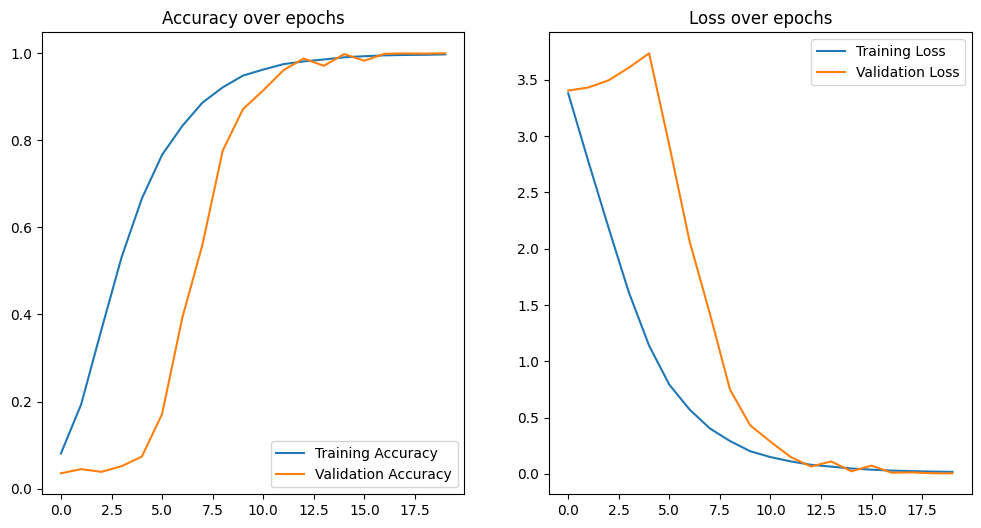

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

> The model demonstrates strong learning performance, with training and validation accuracy both reaching over 99% by the final epoch. The loss continues to decrease, reflecting effective learning. The model appears to be generalizing well, with minimal overfitting, as indicated by the improvements in both training and validation metrics.
___

> **Data Augmentation:**  
Let's now try a augmenting the data and explore the results. We define an augmentation layer applying random rotation (±10%) and random brightness adjustments. The augment_dataset function only applies augmentation to the training dataset, ensuring that the model sees a varied set of images during training, which can help improve generalization.

In [ ]:
from tensorflow.keras import layers

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),       # Rotate +/- 10%
    layers.RandomBrightness(0.1)      # Change brightness
])

# Function to apply data augmentation
def augment_dataset(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                       num_parallel_calls=tf.data.AUTOTUNE)

# Apply data augmentation only to the training dataset
train_dataset = augment_dataset(train_dataset)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1449 - loss: 3.3811 - val_accuracy: 0.3004 - val_loss: 2.4106
Epoch 2/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.2135 - loss: 2.6673 - val_accuracy: 0.4501 - val_loss: 1.7256
Epoch 3/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2640 - loss: 2.4821 - val_accuracy: 0.6697 - val_loss: 1.1102
Epoch 4/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.2892 - loss: 2.3658 - val_accuracy: 0.7509 - val_loss: 0.8342
Epoch 5/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.3156 - loss: 2.2675 - val_accuracy: 0.7538 - val_loss: 0.8391
Epoch 6/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.3408 - loss: 2.1722 - val_accuracy: 0.7498 - val_loss: 0.8393
Epoch 7/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.3549 - loss: 2.1168 - val_accuracy: 0.7819 - val_loss: 0.7439
Epoch 8/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.3726 - loss: 2.0689 - 

Test Accuracy: 80.97%


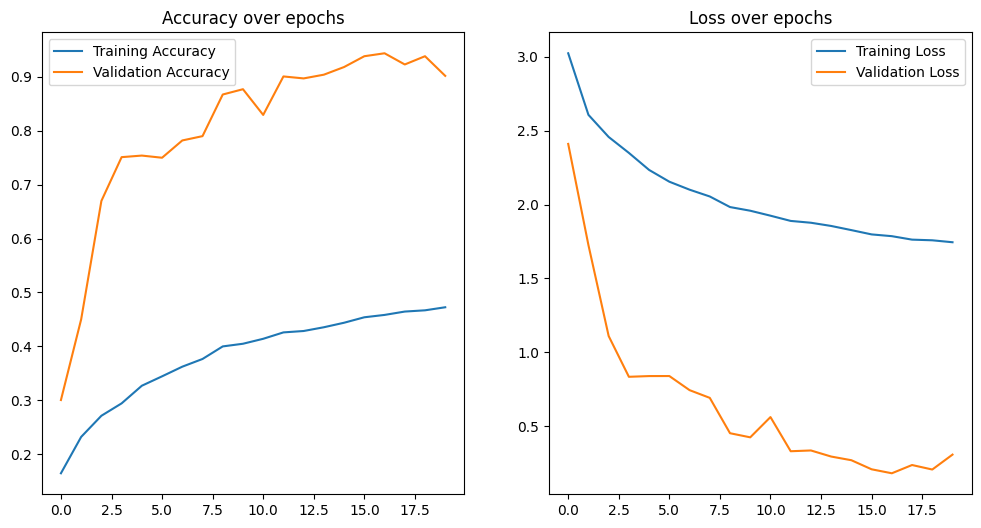

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

> The model learns well and shows steady improvement in both training and validation metrics over 20 epochs. While training accuracy is still relatively low, the validation accuracy reaches over 90%, indicating good generalization. However, there is still room for improvement in the model's performance and it as further tuning or trainig may improve model performance.
___

###**Evaluation, Predictions & Metrics**
> Now we evaluate the model on the test dataset by predicting labels, calculating accuracy, and generating the confusion matrix.

In [ ]:
models_folder = "/content/drive/MyDrive/Models"

# Prepare test dataset
test_dataset = load_dataset_from_dataframe(test_data)

# Load the model
model = tf.keras.models.load_model(models_folder+"/model_01.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 144 variables whereas the saved optimizer has 286 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate the model
y_test = []
y_pred = []
y_probs = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_probs.extend(preds)
    y_test.extend(np.argmax(labels.numpy(), axis=1))

# Metrics calculation
y_test_onehot = label_binarize(y_test, classes=list(range(NUM_CLASSES)))

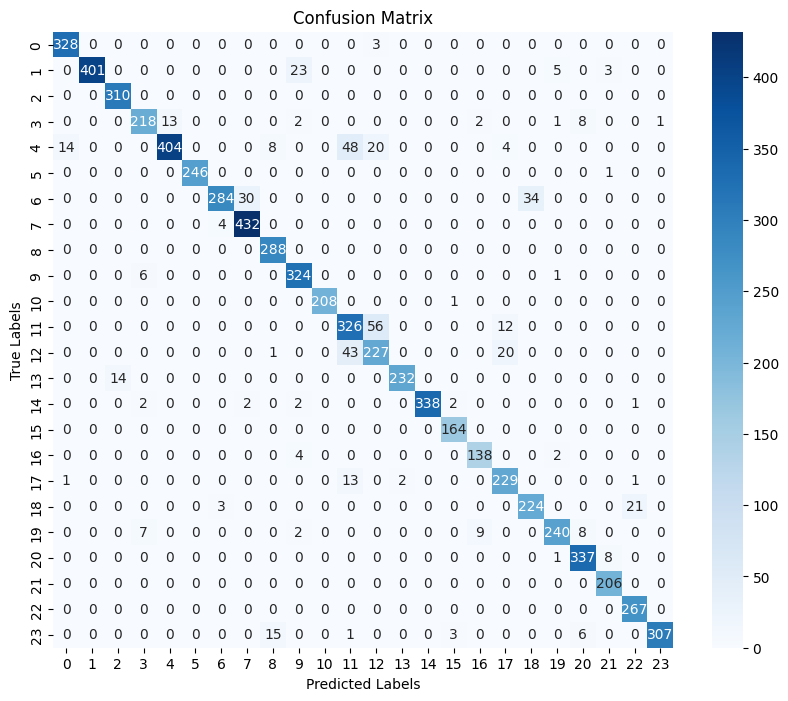

Test Accuracy: 0.9311
F1 Score: 0.9311


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and F1 Score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


> The model performs well on the test dataset, achieving 93.11% accuracy and a 93.11% F1 score. The confusion matrix provides additional insights, showing strong diagonal dominance, which indicates accurate classifications overall. A few instances suggest that the model may have misclassified similar gestures, highlighting potential areas for improvement in distinguishing between certain classes.

In [ ]:
# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 24  # Exclude class 9

# Preprocessing functions
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset_from_dataframe(dataframe):
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
    # Remove samples with label 9
    mask = (labels != 9) & (labels < NUM_CLASSES)
    labels = labels[mask]
    images = images[mask]
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


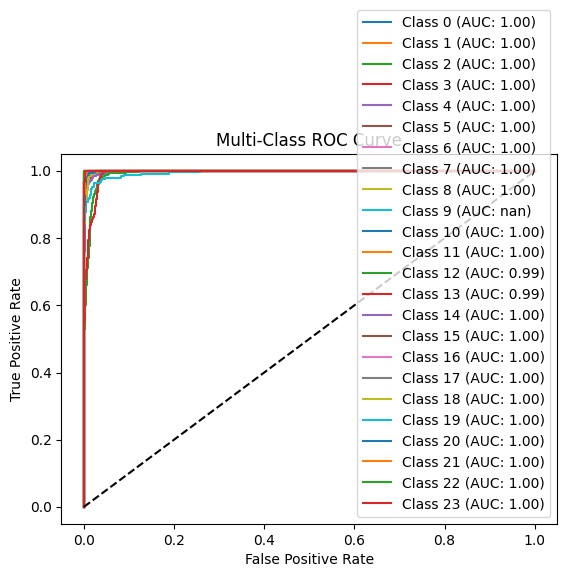

In [ ]:
# ROC and AUC for multi-class
y_probs = np.array(y_probs)
roc_auc_dict = {}
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[i] = roc_auc
    plt.plot(fpr, tpr, label=f'Class {i} (AUC: {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

> Here we vizualize the multi-class ROC curve. Most classes demonstrate perfect performance with an AUC of 1.00, indicating excellent discrimination between correctly classified gestures and misclassifications. Overall, the model shows strong performance across the majority of ASL gestures, effectively distinguishing between different hand signs.

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(NUM_CLASSES)]))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       331
           1       1.00      0.93      0.96       432
           2       0.96      1.00      0.98       310
           3       0.94      0.89      0.91       245
           4       0.97      0.81      0.88       498
           5       1.00      1.00      1.00       247
           6       0.98      0.82      0.89       348
           7       0.93      0.99      0.96       436
           8       0.92      1.00      0.96       288
           9       0.91      0.98      0.94       331
          10       1.00      1.00      1.00       209
          11       0.76      0.83      0.79       394
          12       0.74      0.78      0.76       291
          13       0.99      0.94      0.97       246
          14       1.00      0.97      0.99       347
          15       0.96      1.00      0.98       164
          16       0.93      0.96      0.94       144
    

**Visualize Predictions**
> We use `function plot_random_predictions` to visualizes the true and predicted class labels alongside the predicted class probabilities. The images are presented with their corresponding labels (A-Y for ASL gestures). This can provide valuable insights into how confident the model is in its predictions, showing the class probabilities for each image. This allows a visual understanding of the model’s performance and confidence for individual predictions. Evalutaions broken down into this fashion can be more digestible for potential audiences.

In [ ]:
import random
import string
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_random_predictions(dataset, model, num_images=5):

    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        # Randomly select indices
        indices = random.sample(range(len(images)), num_images)

        # Create a figure
        plt.figure(figsize=(12, 2 * num_images))

        for i, idx in enumerate(indices):
            test_image = images[idx]
            true_label = tf.argmax(labels[idx]).numpy()

            # Predict probabilities
            input_image = tf.expand_dims(test_image, axis=0)
            probabilities = model.predict(input_image)[0]
            pred_label = tf.argmax(probabilities).numpy()

            # Class labels (A-Y for ASL MNIST)
            class_labels = list(string.ascii_uppercase[:len(probabilities)])

            # Plot the image
            plt.subplot(num_images, 2, 2 * i + 1)
            plt.imshow(test_image.numpy().squeeze(), cmap='gray')
            plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")
            plt.axis('off')

            # Plot the class probabilities
            plt.subplot(num_images, 2, 2 * i + 2)
            plt.bar(class_labels, probabilities)
            plt.title("Class Probabilities")
            plt.ylim([0, 1])
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


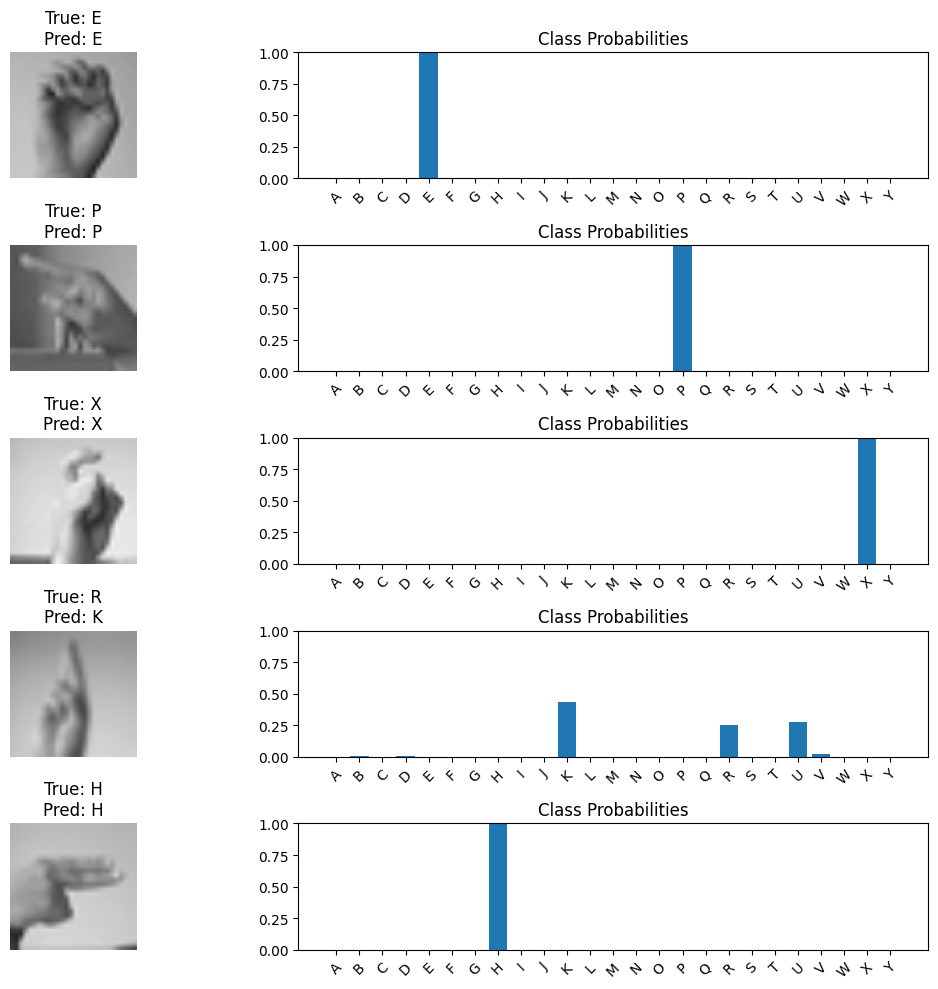

In [ ]:
plot_random_predictions(test_dataset, model, num_images=5)


In [ ]:
#apt-get install -y pandoc

In [ ]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [ ]:
# prompt: Convert this notebook to a pdf with jupyter
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

#sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/Image Classification on American Sign Language.ipynb' --to pdf --template classic


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/traitlets/traitlets.py", line 653, in get
    value = obj._trait_values[self.name]
KeyError: 'template_paths'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 586, in convert_notebooks
    self.exporter = cls(config=self.config)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/ex